In [1]:
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

In [126]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore') 

# Load Data Sets 

In [15]:
from statsmodels.datasets import co2, get_rdataset

# Mauna Loa Weekly Atmospheric CO2 Data
co2_df = co2.load_pandas().data
# set frequency of time series
co2_df = co2_df.interpolate(method='polynomial', order=3) # Interpolate the missing values

#Monthly Airline Passenger Numbers 1949-1960, in thousands
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

Frequency-  W-SAT


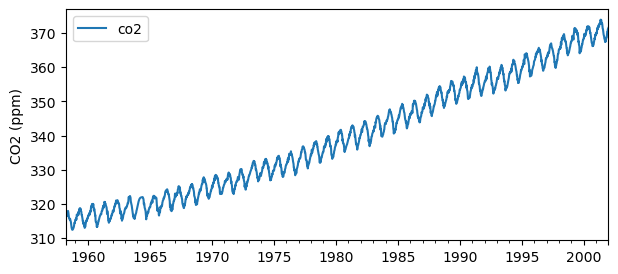

In [21]:
co2_df.plot(figsize=(7, 3))
plt.ylabel('CO2 (ppm)')
plt.show

# get the frequency of the co2 time series
print('Frequency- ',co2_df.index.inferred_freq) 

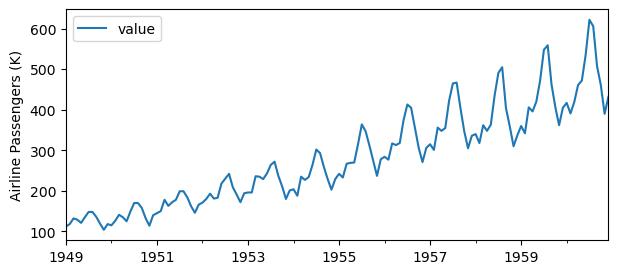

Frequency-  ME


In [20]:
airp_df.plot(figsize=(7, 3))
plt.ylabel('Airline Passengers (K)')
plt.show()
# get the frequency of the airp time series
print('Frequency- ',airp_df.index.inferred_freq)

Frequency-  None
New Frequency-  D


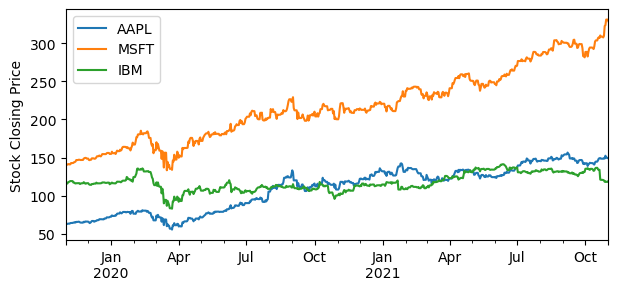

In [81]:
# load the file of stocks closing_price.csv to df from the folder 'Data_sets' 
closing_price = pd.read_csv('./Data_sets/closing_price.csv', index_col='Date', parse_dates=True)

# get the frequency of the closing_price time series
print('Frequency- ',closing_price.index.inferred_freq)

# set the frequency of the closing_price time series (for statmodels functions)
new_index = pd.date_range(start=closing_price.index.min(), end=closing_price.index.max(), freq='D')
closing_price = closing_price.reindex(new_index).fillna(method='ffill') # match weekend and holiday dates for stock market with the previous day's closing price
print('New Frequency- ',closing_price.index.inferred_freq)
# plot the closing_price time series
closing_price.plot(figsize=(7, 3))
plt.ylabel('Stock Closing Price')
plt.show()


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

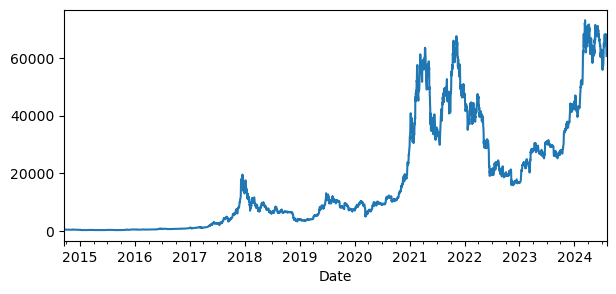

In [140]:
# Downlaod the data of Bitcoin from Yahoo Finance
import yfinance as yf

btc_data = yf.download('BTC-USD', start='2010-01-01', end='2024-08-04')
# Extract the 'Close' price
btc_close = btc_data['Close']
btc_close.plot(figsize=(7, 3))

## Time series Decomposition

### Seasonal Decompose- Additive

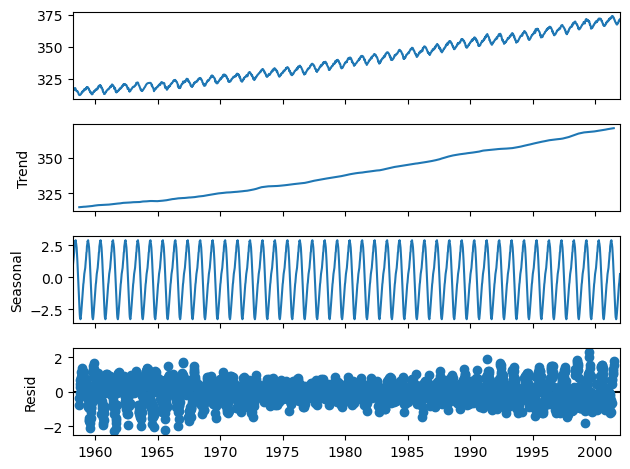

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
# seasonal_decompose period parameter is required  for the seasonal decomposition to work properly (eg, 1 for annual, 12 for monthly, etc)
# However, when using pandas DataFrame or Series with a datetime index, the period parameter is inferred automatically from the datetime index frequency

co2_decomposition = seasonal_decompose(x=co2_df, model='additive') 

co2_trend = co2_decomposition.trend
co2_seasonal = co2_decomposition.seasonal
co2_residual = co2_decomposition.resid
# Plot the decomposed components
co2_decomposition.plot()
plt.show()

#### Examine the residuals 
NaN values in the begining and end because of the moving average opperation window size

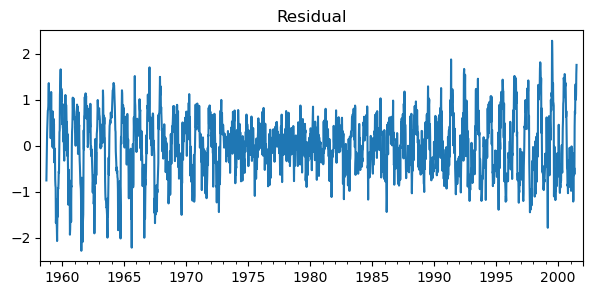

Number of NaN values:
52


In [54]:
co2_residual.plot(figsize=(7, 3), title='Residual')
plt.show()

print('Number of NaN values:')
print(co2_residual.isnull().sum())

#co2_residual.head(27)


#### plot the last 200 values of the residual
Notice leftover seasonality

<Axes: title={'center': 'Residual'}>

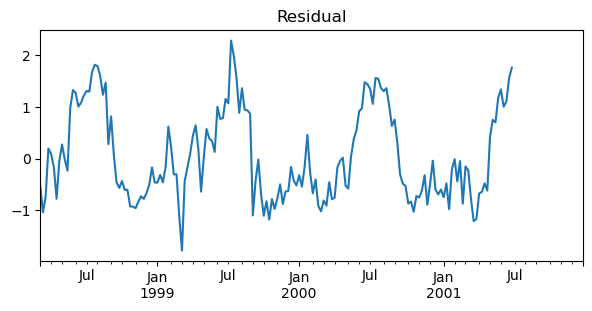

In [56]:
# plot the last 200 values of the residual
co2_residual[-200:].plot(figsize=(7, 3), title='Residual')

### Seasonal Decompose- Multiplicative

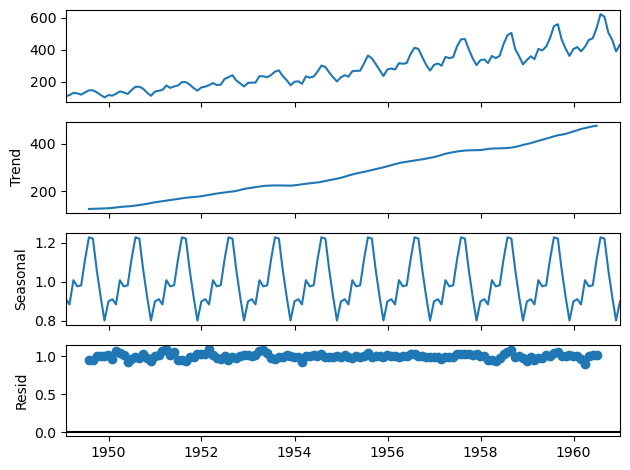

In [58]:
airp_decomposed = seasonal_decompose(airp_df,model='multiplicative')
airp_decomposed.plot()
plt.show()

#### Examine the residuals 

<Axes: title={'center': 'Residual'}>

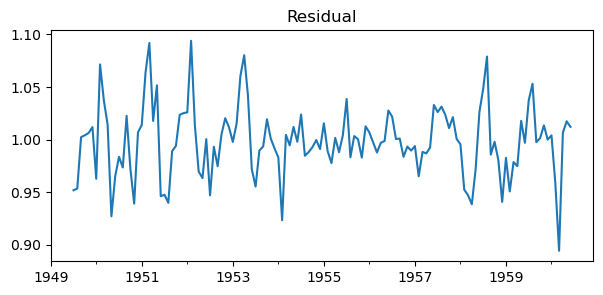

In [59]:
# plot the last 200 values of the residual
airp_decomposed.resid[-200:].plot(figsize=(7, 3), title='Residual')

### STL Decompose
- the STL class requires to define the seasonal parameter, specifies the length of the smoother window
- can only take odd integer values greater than or equal to 7 to ensure that the smoothing window is wide enough to capture meaningful seasonal patterns

In [61]:
from statsmodels.tsa.seasonal import  STL

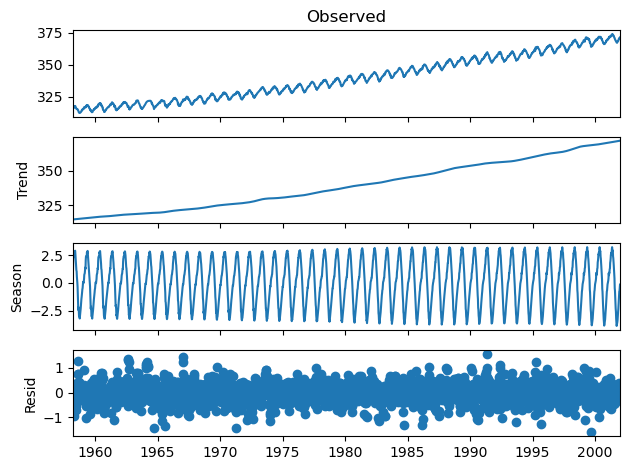

In [76]:
# Apply STL decomposition
co2_stl = STL(co2_df, seasonal=25, robust=True).fit() # seasonal=53 for weekly data on a yearly cycle

# Plot the decomposed components
co2_stl.plot()
plt.show()


<Axes: title={'center': 'Residual'}>

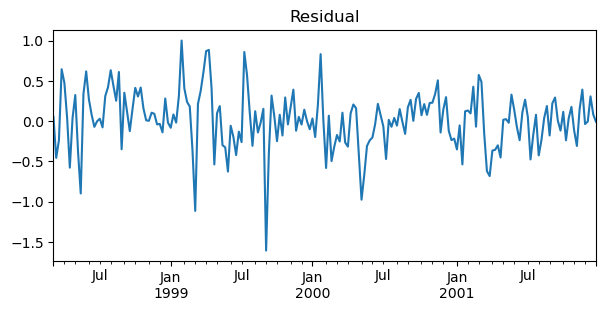

In [77]:
# plot the last 200 values of the residual
co2_stl.resid[-200:].plot(figsize=(7, 3), title='Residual')

# Testing for Stationarity

In [86]:
# create pure random stationary data with mean 0 and standard deviation 1
stationary = np.random.normal(0, 1, 1000)
stationary = pd.Series(stationary, index=pd.date_range('2020-01-01', periods=1000, freq='D'))

## Summary of distribution Statistics
Splits the data into specified number of time frames, calculates mean and variance for each frame,
creates a DataFrame with these statistics, plots the statistics, and prints the DataFrame.



In [100]:

def analyze_time_frames(data, num_time_frames=10):
    """
    Parameters:
    - data: Pandas Series or numpy array containing the time series data
    - num_time_frames: Integer specifying how many time frames to split the data into
    Returns:
    - stats_df: DataFrame containing the mean and variance for each time frame.
    """
    # Split data into specified number of time frames
    time_frames = np.array_split(data, indices_or_sections=num_time_frames)
    # Calculate mean and variance for each time frame individually
    means = [np.mean(frame) for frame in time_frames]
    variances = [np.var(frame) for frame in time_frames]
    # Create a DataFrame with the calculated statistics
    stats_df = pd.DataFrame({'mean': means, 'var': variances})
    # Plotting the statistics
    stats_df.plot(subplots=True, sharex=True, title='time series stats')
    plt.xlabel('Time Frame')
    plt.show()
    # Print the DataFrame
    print(stats_df)

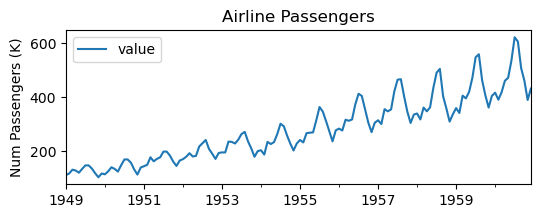

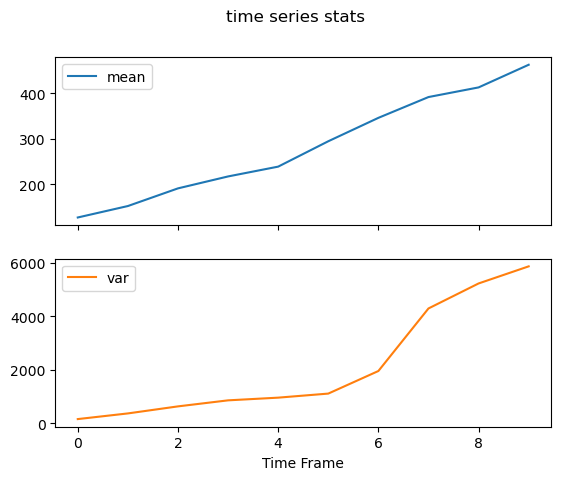

         mean          var
0  126.800000   160.826667
1  152.000000   372.400000
2  190.866667   635.448889
3  217.133333   860.782222
4  238.714286   961.489796
5  294.571429  1113.102041
6  346.071429  1956.494898
7  391.857143  4293.122449
8  413.071429  5226.923469
9  462.928571  5865.637755


In [108]:
# plot airp_df 
airp_df.plot(figsize=(6, 2))
plt.title('Airline Passengers')
plt.ylabel('Num Passengers (K)')
plt.show()

analyze_time_frames(airp_df['value'], num_time_frames=10)



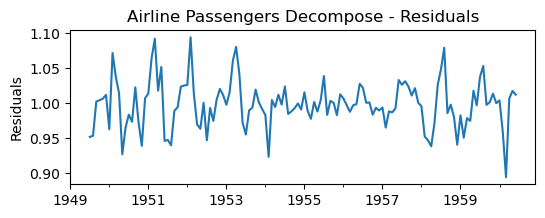

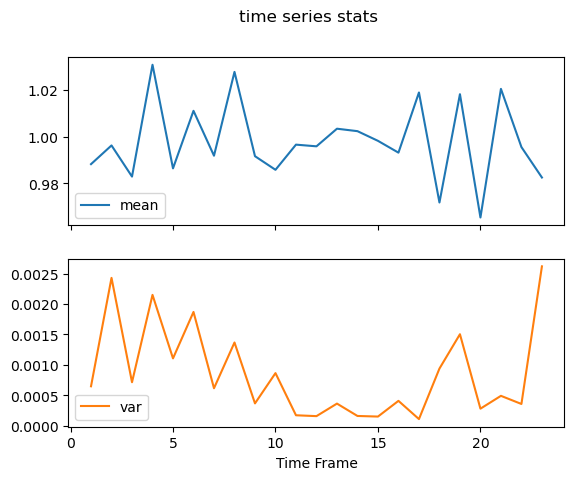

        mean       var
0        NaN       NaN
1   0.988233  0.000646
2   0.996251  0.002431
3   0.982895  0.000713
4   1.030835  0.002151
5   0.986421  0.001106
6   1.011087  0.001870
7   0.991849  0.000614
8   1.027778  0.001367
9   0.991640  0.000364
10  0.985806  0.000863
11  0.996590  0.000169
12  0.995871  0.000155
13  1.003424  0.000361
14  1.002368  0.000157
15  0.998221  0.000147
16  0.993157  0.000406
17  1.018946  0.000106
18  0.971787  0.000938
19  1.018220  0.001503
20  0.965366  0.000277
21  1.020497  0.000489
22  0.995545  0.000355
23  0.982505  0.002621
24       NaN       NaN


In [111]:
# plot airp residuals
airp_decomposed.resid.plot(figsize=(6, 2))
plt.title('Airline Passengers Decompose - Residuals')
plt.ylabel('Residuals')
plt.show()

analyze_time_frames(airp_decomposed.resid, num_time_frames=25)

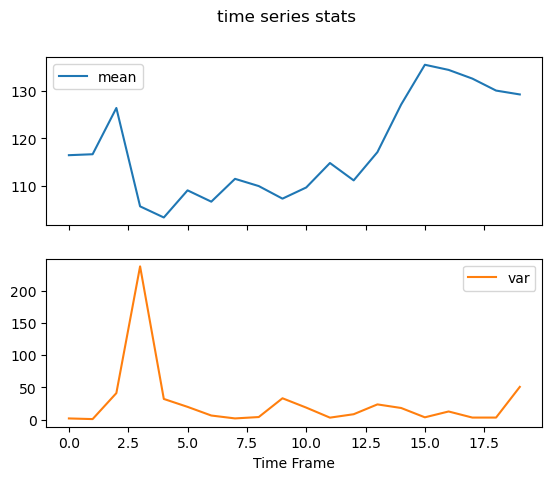

          mean         var
0   116.425835    1.718361
1   116.626925    0.717992
2   126.382697   40.996789
3   105.632594  237.553451
4   103.285819   31.946515
5   109.010486   19.675945
6   106.622482    6.243994
7   111.437220    1.747369
8   109.913114    3.879297
9   107.259779   32.999782
10  109.615352   18.528584
11  114.776838    2.956991
12  111.113702    8.251159
13  117.068403   23.491506
14  127.107847   17.925535
15  135.501501    3.457216
16  134.417505   12.512103
17  132.581987    3.067368
18  130.055205    3.066084
19  129.239920   50.648921


In [112]:
analyze_time_frames(closing_price['IBM'], num_time_frames=20)

## Histogram Plot  
A Normal distribution is an indication that mean and variance are constant. 
* we could use additional methods like SciPy's [normaltest] to check whether this distribution differs from normal 

array([[<Axes: title={'center': 'value'}>]], dtype=object)

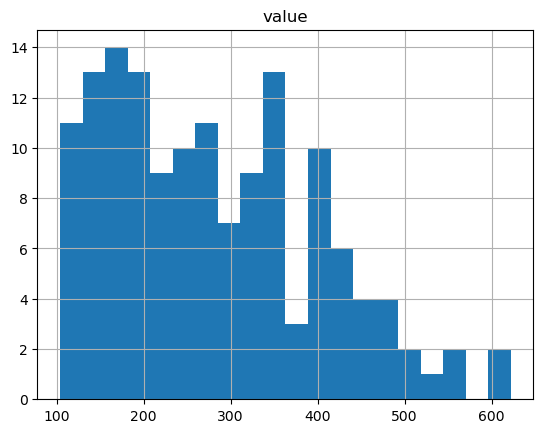

In [113]:
airp_df.hist(bins=20)

<Axes: >

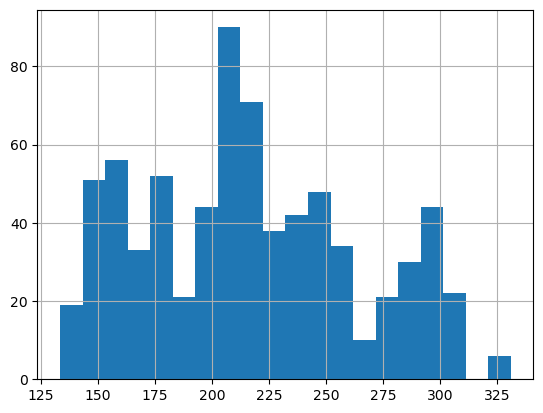

In [114]:
closing_price['MSFT'].hist(bins=20)

<Axes: >

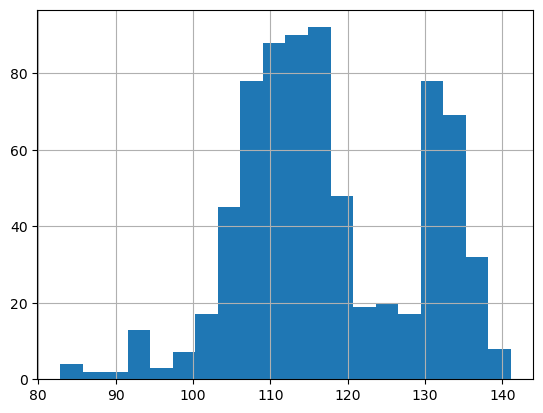

In [115]:
closing_price['IBM'].hist(bins=20)

<Axes: >

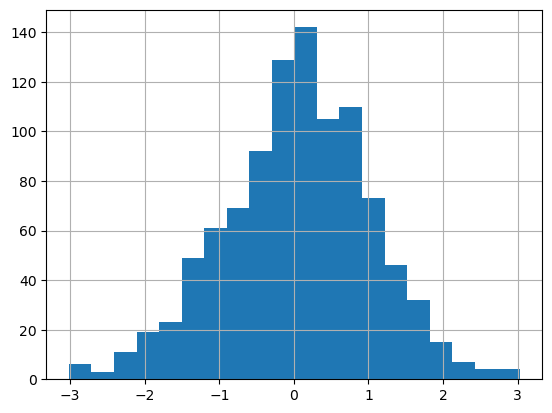

In [116]:
stationary.hist(bins=20)

## Augmented Dickey Fuller Test
Statistical test to detect whether a time series is stationary or not. 
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

set a significance level or threshold (normaly p_value=0.05) that determines whether you should accept or reject the null hypothesis. 

In [124]:
from statsmodels.tsa.stattools import adfuller, kpss

In [127]:
result_ADF = adfuller(co2_df['co2']) 
# Output the test statistic and p-value
print('ADF Statistic:', result_ADF[0])
print('ADF p-value:', result_ADF[1])

results_KPSS = kpss(co2_df['co2'])
# Output the test statistic and p-value
print('KPSS Statistic:', results_KPSS[0])
print('KPSS p-value:', results_KPSS[1])



ADF Statistic: -0.03901030678437898
ADF p-value: 0.9551845823204432
KPSS Statistic: 7.648294088524415
KPSS p-value: 0.01


In [128]:
# Test ADF for co2 residuals
result_ADF = adfuller(co2_residual.dropna())
print('ADF Statistic:', result_ADF[0])
print('p-value:', result_ADF[1])
# Test KPSS for co2 residuals
results_KPSS = kpss(co2_residual.dropna())
print('KPSS Statistic:', results_KPSS[0])
print('p-value:', results_KPSS[1])

ADF Statistic: -15.837646261862998
p-value: 9.776194812376556e-29
KPSS Statistic: 0.008632733932027284
p-value: 0.1


In [123]:
result = adfuller(closing_price['IBM'])

# Output the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.3918798719654597
p-value: 0.1440413832471804


In [122]:
result = adfuller(stationary)

# Output the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -23.505612682119622
p-value: 0.0


# Stationary Transformations

## Moving average

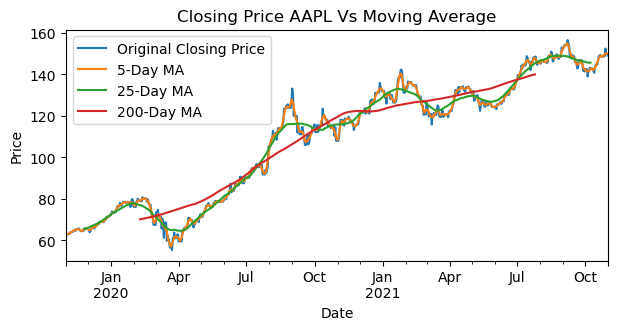

In [160]:
AAPL= closing_price['AAPL']

# Calculate the centered moving average (CMA) with different time windows
MA_5d = AAPL.rolling(window=5, center=True).mean()
MA_50d = AAPL.rolling(window=50, center=True).mean()
MA_200d = AAPL.rolling(window=200, center=True).mean()

# Plotting the original closing prices and the moving average

plt.figure(figsize=(7, 3))
AAPL.plot(label='Original Closing Price')
MA_5d.plot(label='5-Day MA')
MA_25d.plot(label='25-Day MA')
MA_200d.plot(label='200-Day MA')
plt.title('Closing Price AAPL Vs Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

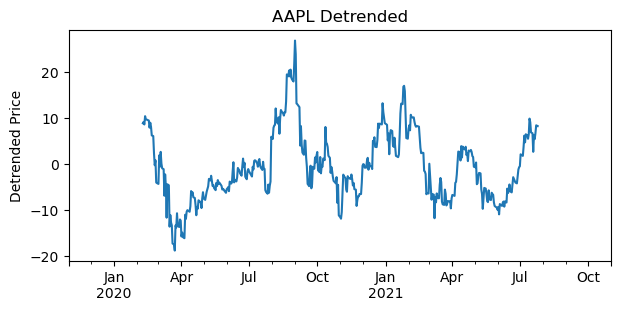

In [159]:
# Detrend the data by subtracting the 200-day moving average
AAPL_detrended = AAPL - MA_200d
# plot the detrended data
AAPL_detrended.plot(figsize=(7, 3))
plt.title('AAPL Detrended')
plt.ylabel('Detrended Price')
plt.show()


### Moving Average to remove Trend and Seasonality

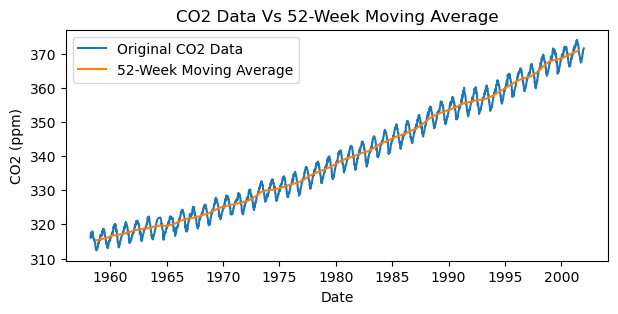

In [139]:
# Moving Average to remove Seasonality

# Calculate the centered moving average of co2_df with a window of 52 weeks (1 year)
co2_MA = co2_df.rolling(window=52, center=True).mean()

# Plot the original data and the moving average on the same plot
plt.figure(figsize=(7, 3))
plt.plot(co2_df, label='Original CO2 Data')
plt.plot(co2_MA, label='52-Week Moving Average')
plt.title('CO2 Data Vs 52-Week Moving Average')
plt.xlabel('Date')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.show()


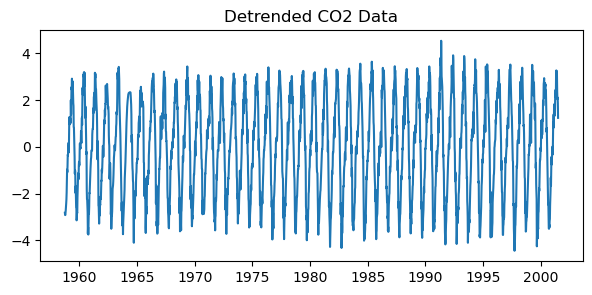

In [138]:
# Subtract the moving average from the original data
co2_detrended = co2_df - co2_MA
# Plot the detrended data
plt.figure(figsize=(7, 3))
plt.plot(co2_detrended, label='Detrended CO2 Data')
plt.title('Detrended CO2 Data')
plt.show()

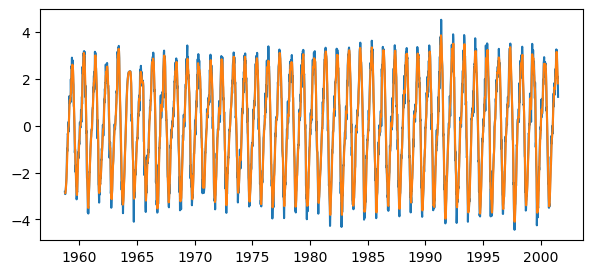

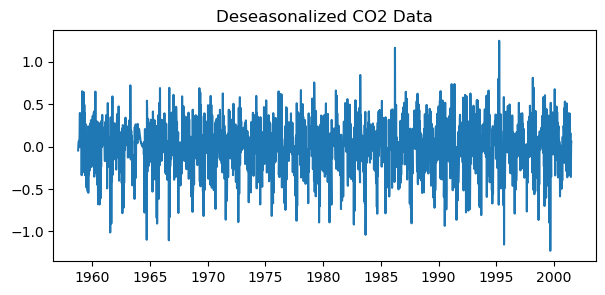

In [157]:
# use moving average to remove seasonality from co2_detrended
co2_detrended_MA = co2_detrended.rolling(window=4, center=True).mean() # 4 weeks
# plot the detrended data and the moving average
plt.figure(figsize=(7, 3))
plt.plot(co2_detrended, label='Detrended CO2 Data')
plt.plot(co2_detrended_MA, label='52-Week Moving Average')
plt.show()

# Subtract the moving average from the detrended data
co2_deseasonalized = co2_detrended - co2_detrended_MA
# Plot the deseasonalized data
plt.figure(figsize=(7, 3))
plt.plot(co2_deseasonalized, label='Deseasonalized CO2 Data')
plt.title('Deseasonalized CO2 Data')
plt.show()

## Log Transform
- natural logarithm in base e

### Apply Log transform to Bitcoin data 

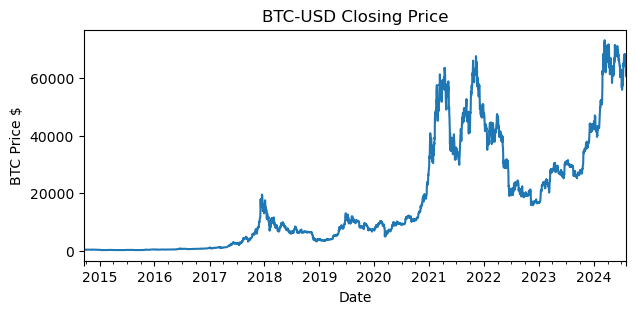

In [142]:
# plot the closing price
btc_close.plot(title='BTC-USD Closing Price', figsize=(7, 3)) 
plt.ylabel('BTC Price $')
plt.show()

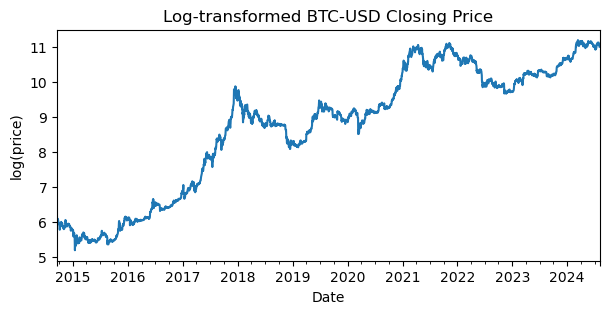

In [144]:
 # Apply the log transformation
btc_log = np.log(btc_close) # log transformation base e
# Plot the log-transformed data
btc_log.plot(title='Log-transformed BTC-USD Closing Price', figsize=(7, 3))
# set y axis label to 'log(price)'
plt.ylabel('log(price)')
plt.show()

## Fitting regression curve and de-trending the data

### Linear regression

Slope: 0.0015988486946560204
Intercept: 5.835749276070155
R^2: 0.8581457071824569


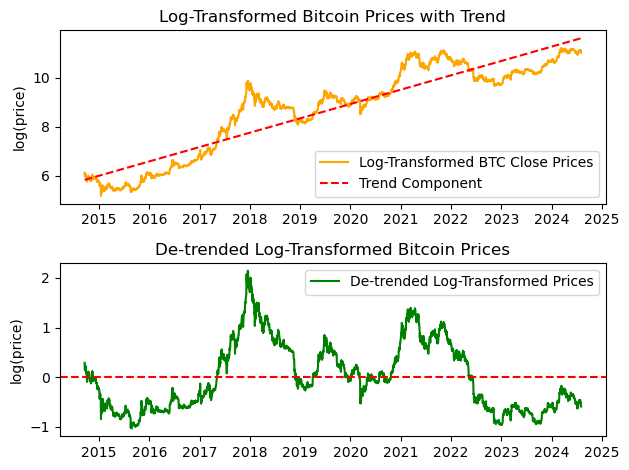

In [145]:
# Generate a time index for the log-transformed data
time_index = np.arange(len(btc_close))
# Perform linear regression to find the trend and r^2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(time_index, btc_log)
# Calculate the trend component
trend = slope * time_index + intercept
# De-trend the log-transformed data by subtracting the trend
btc_detrended = btc_log - trend

# print the slope and intercept
print('Slope:', slope)
print('Intercept:', intercept)
#print the r^2 value
print('R^2:', r_value**2)

# plot btc_log with the trend on the same plot
# plot btc_detrended on a separate plot
plt.subplot(2, 1, 1)
plt.plot(btc_log, label='Log-Transformed BTC Close Prices', color='orange')
plt.plot(btc_log.index,trend, label='Trend Component', color='red', linestyle='--')
plt.title('Log-Transformed Bitcoin Prices with Trend')
plt.ylabel('log(price)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(btc_detrended, label='De-trended Log-Transformed Prices', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('De-trended Log-Transformed Bitcoin Prices')
plt.ylabel('log(price)')
plt.legend()

plt.tight_layout()
plt.show()

### Exponential regression

Fitted exponential parameters: a = 12395.188272623025, b = 0.0004731524699285554, c = -15462.467615310577
R^2 value: 0.6760022500253204


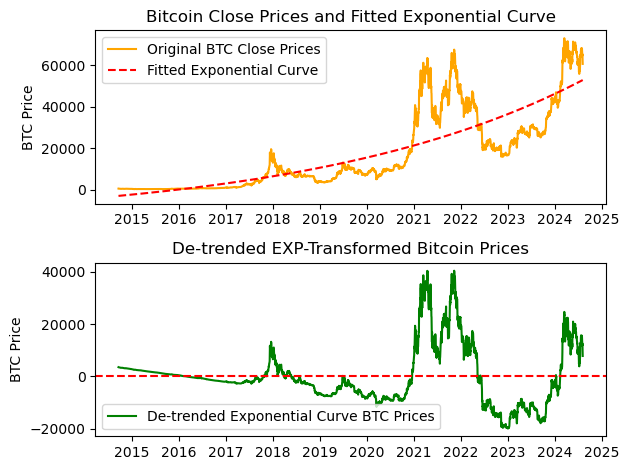

In [162]:
# Define an exponential function to fit using curve_fit
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c
# Generate a time index for fitting
time_index = np.arange(len(btc_close))
# Perform the curve fitting
popt, pcov = curve_fit(exponential_func, time_index, btc_close, p0=(1, 0.0001, 1))
# Extract the parameters
a, b, c = popt

# Generate fitted exponential curve
btc_exp_fitted = exponential_func(time_index, a, b, c)
# get r^2 value
r_squared = np.corrcoef(btc_close, btc_exp_fitted)[0, 1]**2
#de-trend the data
btc_exp_detrended = btc_close - btc_exp_fitted

# Print the fitted parameters
print(f"Fitted exponential parameters: a = {a}, b = {b}, c = {c}")
print(f"R^2 value: {r_squared}")

# plot btc_log with the trend on the same plot
plt.subplot(2, 1, 1)
plt.plot(btc_close, label='Original BTC Close Prices', color='orange')
plt.plot(btc_close.index,btc_exp_fitted, label='Fitted Exponential Curve', color='red', linestyle='--')
plt.title('Bitcoin Close Prices and Fitted Exponential Curve')
plt.ylabel('BTC Price')
plt.legend()
# plot btc_detrended on a separate plot
plt.subplot(2, 1, 2)
plt.plot(btc_exp_detrended, label='De-trended Exponential Curve BTC Prices', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('De-trended EXP-Transformed Bitcoin Prices')
plt.ylabel('BTC Price')
plt.legend()
plt.tight_layout()
plt.show()


## Differencing

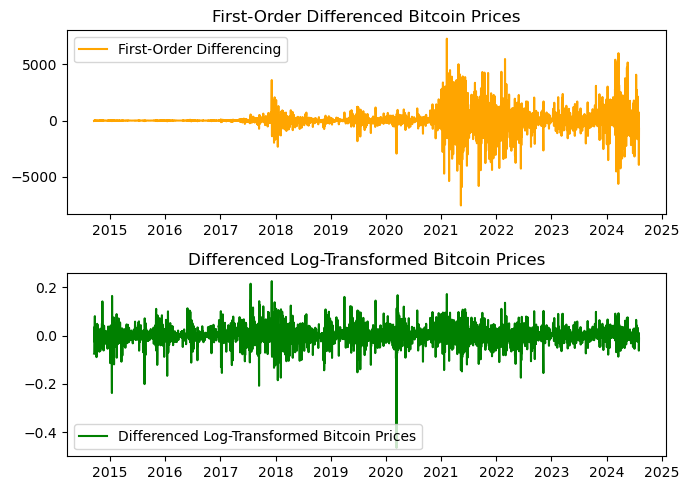

ADF Statistic (First-Order Differencing): -9.589837216525838
p-value (First-Order Differencing): 2.0500966939077987e-16
ADF Statistic (Log-Transform Differencing): -18.253637926573347
p-value (Log-Transform Differencing): 2.3397834562125365e-30


In [164]:
# Apply first-order differencing
btc_diff_1 = btc_close.diff().dropna()
# Apply First-order differencing to the log-transformed data
btc_log_diff_1 = btc_log.diff().dropna()


# plot the differenced series and the differenced log-transformed series
fig, axs = plt.subplots(2, 1, figsize=(7, 5))
# Plot first-order differenced series
axs[0].plot(btc_diff_1, label='First-Order Differencing', color='orange')
axs[0].set_title('First-Order Differenced Bitcoin Prices')
axs[0].legend()
# Plot differenced log transformed series
axs[1].plot(btc_log_diff_1, label='Differenced Log-Transformed Bitcoin Prices', color='green')
axs[1].set_title('Differenced Log-Transformed Bitcoin Prices')
axs[1].legend()
plt.tight_layout()
plt.show()

# Check stationarity using Augmented Dickey-Fuller test
# ADF test for first-order differenced series
adf_test_1 = adfuller(btc_diff_1)
print(f'ADF Statistic (First-Order Differencing): {adf_test_1[0]}')
print(f'p-value (First-Order Differencing): {adf_test_1[1]}')

# ADF test for second-order differenced series
adf_test_2 = adfuller(btc_log_diff_1)
print(f'ADF Statistic (Log-Transform Differencing): {adf_test_2[0]}')
print(f'p-value (Log-Transform Differencing): {adf_test_2[1]}')


### Seasonal Differencing

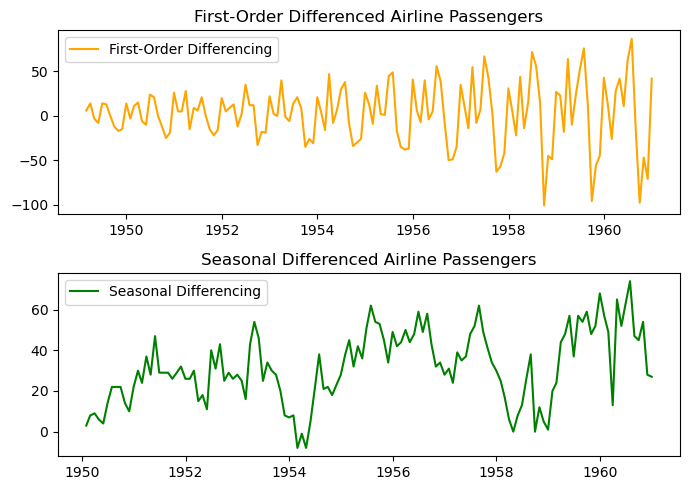

In [167]:
# Apply normal differencing to the air_p data
airp_diff = airp_df['value'].diff().dropna()

# Apply seasonal differencing to the air_p data
airp_seasonal_diff = airp_df['value'].diff(12).dropna()

# Plot the normal and the seasonal differenced data
fig, axs = plt.subplots(2, 1, figsize=(7, 5))
# Plot normal differenced data
axs[0].plot(airp_diff, label='First-Order Differencing', color='orange')
axs[0].set_title('First-Order Differenced Airline Passengers')
axs[0].legend()
# Plot seasonal differenced data
axs[1].plot(airp_seasonal_diff, label='Seasonal Differencing', color='green')
axs[1].set_title('Seasonal Differenced Airline Passengers')
axs[1].legend()
plt.tight_layout()
plt.show()


## Reverse Transformation

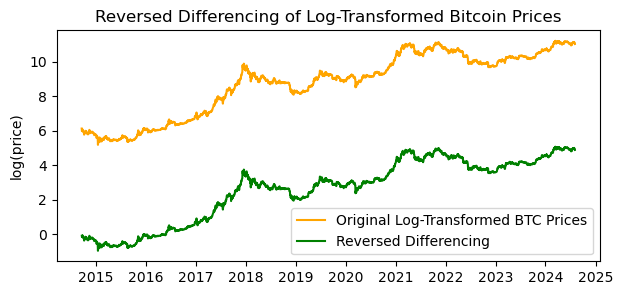

In [173]:
## Reverse the differencing from btc_log_diff_1
btc_log_diff_1_reversed = btc_log_diff_1.cumsum()

#plot the original log-transformed data and the reversed differencing
plt.figure(figsize=(7, 3))
plt.plot(btc_log, label='Original Log-Transformed BTC Prices', color='orange')
plt.plot(btc_log_diff_1_reversed, label='Reversed Differencing', color='green')
plt.title('Reversed Differencing of Log-Transformed Bitcoin Prices')
plt.ylabel('log(price)')
plt.legend()
plt.show()

# add the first value of the original log-transformed data to the reversed differencing
btc_log_diff_1_reversed_add_value = btc_log_diff_1_reversed + btc_log[0]

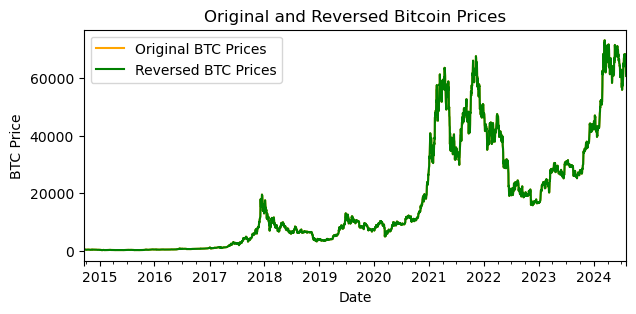

In [174]:
# reverse the log transformation
btc_reversed = np.exp(btc_log_diff_1_reversed_add_value)
# put back in df
btc_reversed = pd.Series(btc_reversed, index=btc_close.index)
# plot the original data and the reversed data
plt.figure(figsize=(7, 3))
btc_close.plot(label='Original BTC Prices', color='orange')
btc_reversed.plot(label='Reversed BTC Prices', color='green')
plt.title('Original and Reversed Bitcoin Prices')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# Autocorrelation Function (ACF) 

In [183]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

### Explore ACF of Air Passengers 

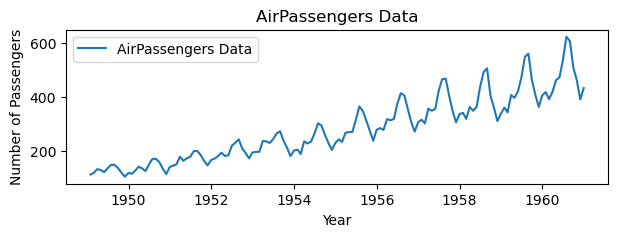

<Figure size 800x200 with 0 Axes>

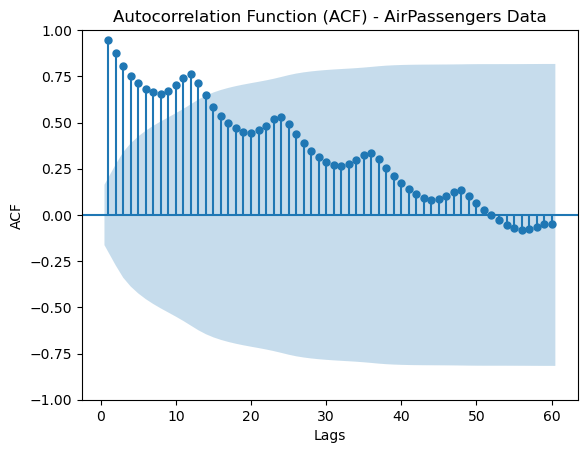

In [186]:
## Autocorrelation Function (ACF) of AirPassengers interpretation
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF of the AirPassengers data
# Plot the original data
plt.figure(figsize=(7, 2))
plt.plot(airp_df.index, airp_df['value'], label='AirPassengers Data')
plt.title('AirPassengers Data')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Plot the ACF of the AirPassengers data
plt.figure(figsize=(8, 2))
plot_acf(airp_df['value'], lags=60, zero=False)
plt.title('Autocorrelation Function (ACF) - AirPassengers Data')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()


### Explore ACF of BTC prices and transformations

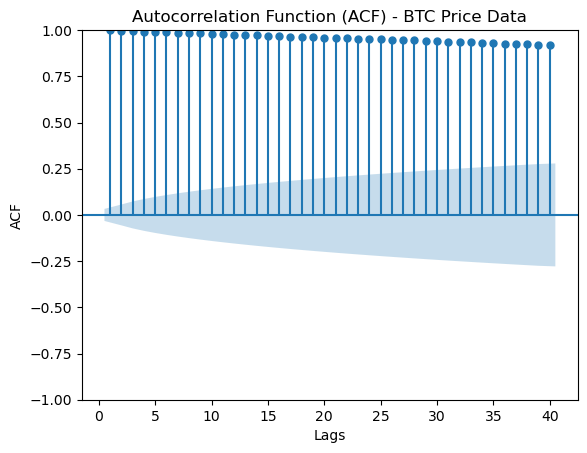

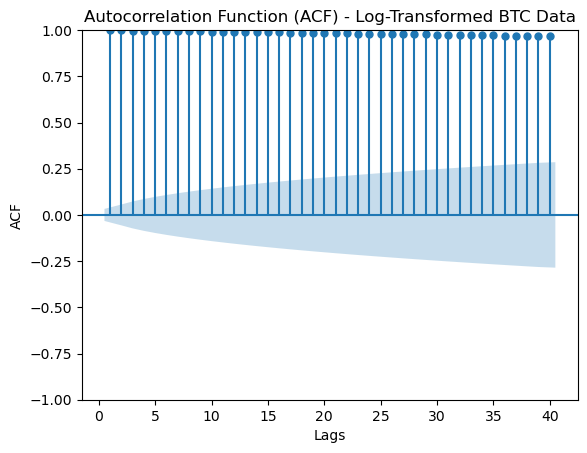

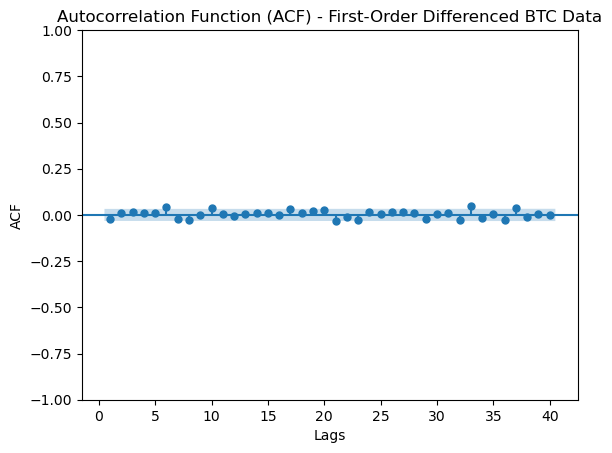

In [198]:
# Plot the ACF of the BTC price data 
plot_acf(btc_close, lags=40, zero=False)
plt.title('Autocorrelation Function (ACF) - BTC Price Data')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# Plot the ACF of the BTC-Log transformed data 
plot_acf(btc_log, lags=40, zero=False)
plt.title('Autocorrelation Function (ACF) - Log-Transformed BTC Data')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# Plot the ACF of the first-order differenced BTC data
plot_acf(btc_log_diff_1, lags=40, zero=False)
plt.title('Autocorrelation Function (ACF) - First-Order Differenced BTC Data')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

## Partial Autocorrelation Function (PACF) 

In [191]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

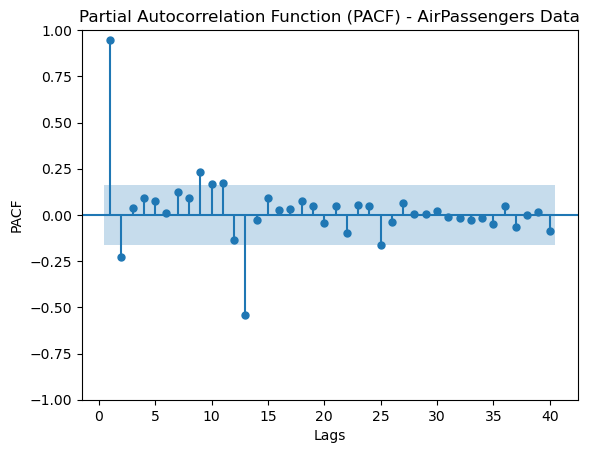

In [199]:
# Plot the PACF of the AirPassengers data
plot_pacf(airp_df['value'], lags=40, method='ywm', zero=False)
plt.title('Partial Autocorrelation Function (PACF) - AirPassengers Data')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()


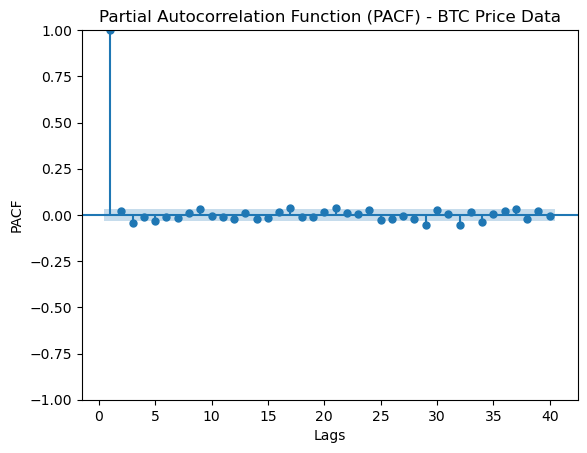

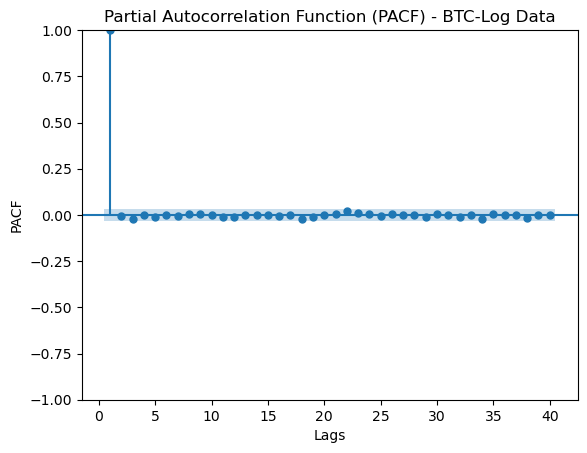

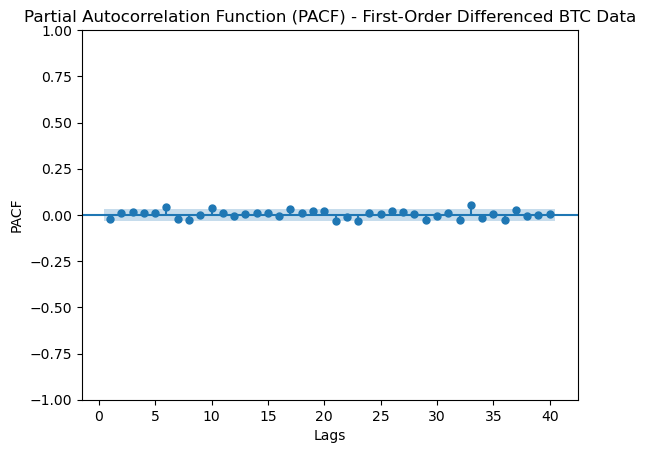

In [202]:
# Plot the Partial ACF of the BTC price data
plot_pacf(btc_close, lags=40, zero=False)
plt.title('Partial Autocorrelation Function (PACF) - BTC Price Data')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

# Plot the Partial ACF of the BTC-Log data
plot_pacf(btc_log, lags=40, zero=False)
plt.title('Partial Autocorrelation Function (PACF) - BTC-Log Data')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

# Plot the Partial ACF of the first-order differenced BTC data
plot_pacf(btc_log_diff_1, lags=40, zero=False)
plt.title('Partial Autocorrelation Function (PACF) - First-Order Differenced BTC Data')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()
